In [30]:
# checkpoint_path = '../models/transformers/grokking_prod_120_1_0.1_attnonly_False20240712_133838.pt'



transformer_config = dict(
    d_vocab=512,
    n_layers=1,
    d_model=1024,
    d_head=128,
    n_heads=4,
    d_mlp=256,
    n_ctx=5,
    act_fn="relu",  # gelu?
    normalization_type='LN',
    attn_only=False,
)

In [84]:
checkpoint_path = './multiplication_model.pt'

transformer_config = dict(
    d_vocab=512,
    n_layers=1,
    d_model=1024,
    d_head=256,
    n_heads=4,
    d_mlp=4096,
    n_ctx=5,
    act_fn="relu",  # gelu?
    normalization_type=None,
    attn_only=False,
)

In [85]:
from argparse import Namespace
from dataclasses import dataclass, asdict

In [86]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    from prettytable import PrettyTable

    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [87]:
import logging
import torch
from dataclasses import dataclass, asdict
import numpy as np
import time
import os
from tqdm.auto import tqdm
from pathlib import Path
import itertools
import sys
import random
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import argparse
from transformer_lens import HookedTransformer, HookedTransformerConfig
import wandb
from dotenv import load_dotenv
from sympy import factorint
from itertools import product
from math import prod

import os
import random
import numpy as np
import torch
from tqdm.auto import tqdm

In [88]:
def get_device():
    #return 'cpu'
    if torch.cuda.is_available():
        return "cuda"
    # elif torch.backends.mps.is_available():
    #     return "mps"
    else:
        return "cpu"


device = get_device()

In [89]:
import sys
sys.path.append('..')

from data import create_datasets, seed_all, DataParams, Tokens, OOCL_Dataset, make_tbl_mask, create_orig_data, yield_data

In [90]:
seed = 0

In [91]:
seed_all(seed)

mod = DataParams.mod
# divide the integers into 4 equally sized sets
size = mod // 4
rem = mod % 4

In [92]:
new_transformer_config = transformer_config
new_transformer_config.update(dict(
    d_vocab=2*mod + 4,  # 3 special tokens + mod vars
))
new_cfg = HookedTransformerConfig(**new_transformer_config)
new_model = HookedTransformer(new_cfg)
state_dict = torch.load(checkpoint_path, map_location='cpu')
new_model.load_state_dict(state_dict)
new_model.to(get_device())

model = new_model

Moving model to device:  cpu


In [93]:
# Helper variables
W_O = model.blocks[0].attn.W_O
W_K = model.blocks[0].attn.W_K
W_Q = model.blocks[0].attn.W_Q
W_V = model.blocks[0].attn.W_V
W_in = model.blocks[0].mlp.W_in
W_out = model.blocks[0].mlp.W_out
W_pos = model.pos_embed.W_pos.T
# We remove the equals sign dimension from the Embed and Unembed, so we can
# apply a Fourier Transform over R^p
W_E = model.embed.W_E[:120, :]
W_U = model.unembed.W_U[:, :120]

print('W_O', W_O.shape)
print('W_K', W_K.shape)
print('W_Q', W_Q.shape)
print('W_V', W_V.shape)
print('W_in', W_in.shape)
print('W_out', W_out.shape)
print('W_pos', W_pos.shape)
print('W_E', W_E.shape)
print('W_U', W_U.shape)

all_data = torch.tensor([(i, j, mod) for i in range(mod) for j in range(mod)]).to(torch.int64).to(device)
labels = torch.tensor([i*j % mod for i, j, _ in all_data]).to(torch.int64).to(device)

# test to make sure model is correctly predicting the labels

test_logits = model(all_data)[:, -1, :].squeeze()

print(F.cross_entropy(test_logits, labels))

# get accuracy
def get_accuracy(logits, labels):
    return torch.mean((torch.argmax(logits, dim=-1) == labels).float())

with torch.no_grad():
  full_logits, full_cache = model.run_with_cache(all_data)


W_O torch.Size([4, 256, 1024])
W_K torch.Size([4, 1024, 256])
W_Q torch.Size([4, 1024, 256])
W_V torch.Size([4, 1024, 256])
W_in torch.Size([1024, 4096])
W_out torch.Size([4096, 1024])
W_pos torch.Size([1024, 5])
W_E torch.Size([120, 1024])
W_U torch.Size([1024, 120])
tensor(0.0830, grad_fn=<NllLossBackward0>)


In [94]:
# W_O torch.Size([4, 256, 1024])
# W_K torch.Size([4, 1024, 256])
# W_Q torch.Size([4, 1024, 256])
# W_V torch.Size([4, 1024, 256])
# W_in torch.Size([1024, 4096])
# W_out torch.Size([4096, 1024])
# W_pos torch.Size([1024, 5])
# W_E torch.Size([120, 1024])
# W_U torch.Size([1024, 120])

# tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward0>)



In [95]:
count_parameters(model)

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
|     embed.W_E      |   249856   |
|  pos_embed.W_pos   |    5120    |
| blocks.0.attn.W_Q  |  1048576   |
| blocks.0.attn.W_O  |  1048576   |
| blocks.0.attn.b_Q  |    1024    |
| blocks.0.attn.b_O  |    1024    |
| blocks.0.attn.W_K  |  1048576   |
| blocks.0.attn.W_V  |  1048576   |
| blocks.0.attn.b_K  |    1024    |
| blocks.0.attn.b_V  |    1024    |
| blocks.0.mlp.W_in  |  4194304   |
| blocks.0.mlp.b_in  |    4096    |
| blocks.0.mlp.W_out |  4194304   |
| blocks.0.mlp.b_out |    1024    |
|    unembed.W_U     |   249856   |
|    unembed.b_U     |    244     |
+--------------------+------------+
Total Trainable Params: 13097204


13097204

In [96]:
import plotly.express as px


def imshow(tensor, **kwargs):
    px.imshow(
        np.asarray(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=np.asarray(tensor),
        **kwargs,
    ).show()

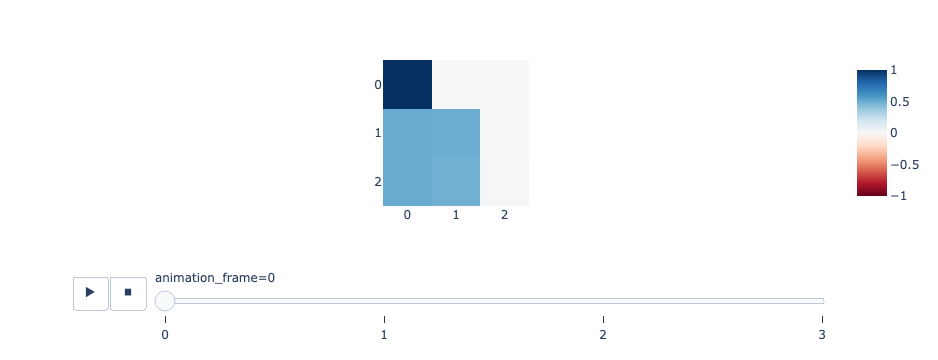

In [97]:
attn_pattern = full_cache['blocks.0.attn.hook_pattern']

imshow(attn_pattern.mean(dim=0), animation_frame=0)

tensor(0.0786)


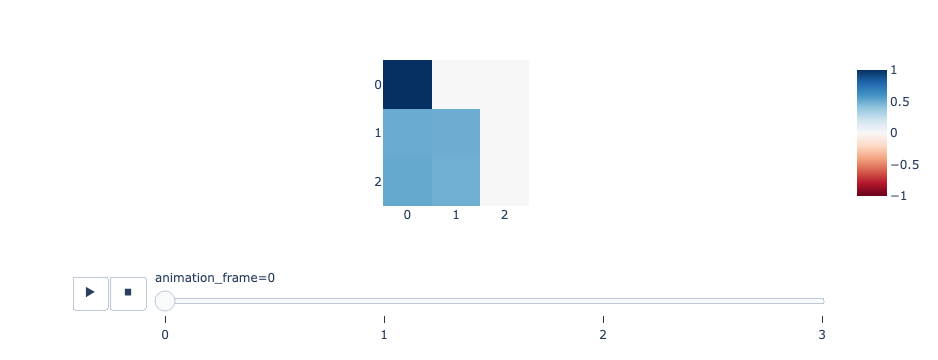

In [98]:
from transformer_lens import utils

def patch_attn_mat_eq(
    attention_scores,
    hook,
):

    attention_scores[:, :, 2, 2] = -1000000000000
    return attention_scores

model.remove_all_hook_fns()
model.add_hook(utils.get_act_name('attn_scores', 0), patch_attn_mat_eq)

with torch.no_grad():
  patched_logits, patched_cache = model.run_with_cache(all_data)

torch.cuda.empty_cache()

print(F.cross_entropy(patched_logits[:, -1, :].squeeze(), labels))

attn_pattern_patched = patched_cache['blocks.0.attn.hook_pattern']

imshow(attn_pattern_patched.mean(dim=0), animation_frame=0)


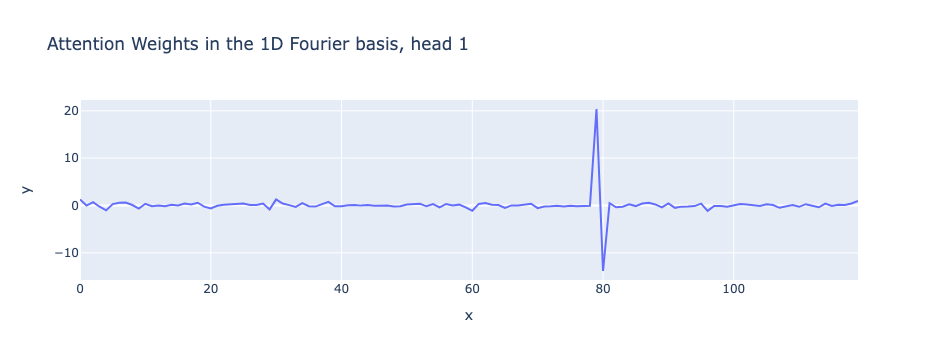

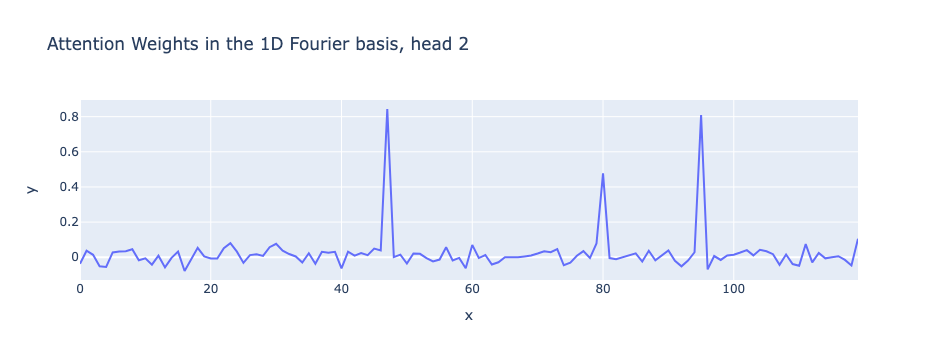

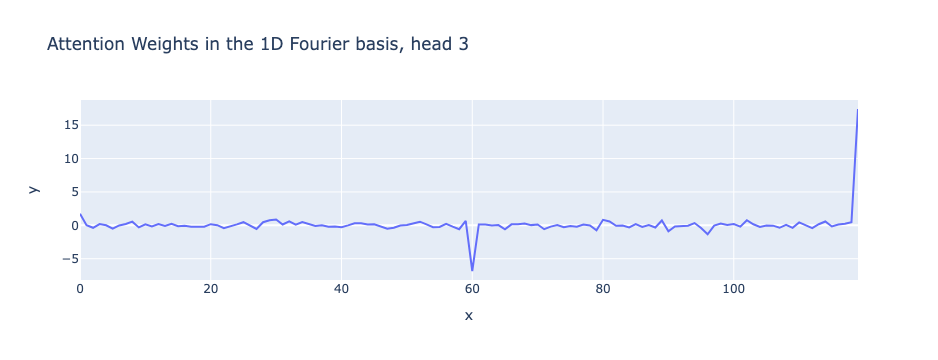

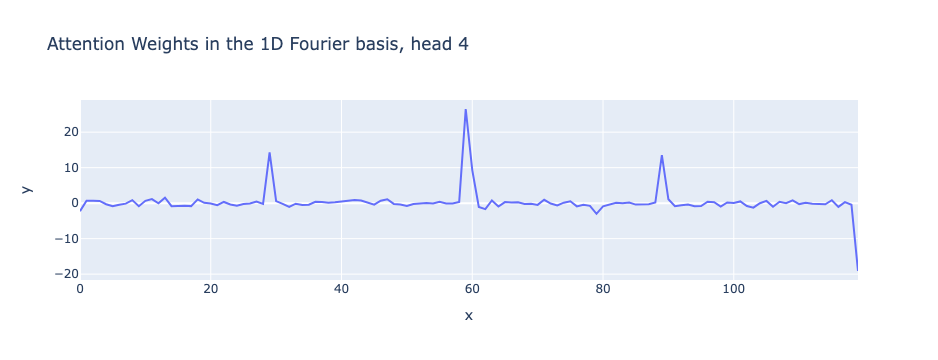

In [99]:
p = 120


fourier_basis = []
fourier_basis.append(torch.ones(p)/np.sqrt(p))
fourier_basis_names = ['Const']
# Note that if p is even, we need to explicitly add a term for cos(kpi), ie
# alternating +1 and -1
for i in range(1, p//2):
    fourier_basis.append(torch.cos(2*torch.pi*torch.arange(p)*i/p))
    fourier_basis.append(torch.sin(2*torch.pi*torch.arange(p)*i/p))
    fourier_basis[-2]/=fourier_basis[-2].norm()
    fourier_basis[-1]/=fourier_basis[-1].norm()
    fourier_basis_names.append(f'cos {i}')
    fourier_basis_names.append(f'sin {i}')

if p % 2 == 0:
    cos_kpi = torch.cos(torch.pi * torch.arange(p))
    fourier_basis.append(cos_kpi / cos_kpi.norm())
    fourier_basis_names.append(f'cos {p // 2}')
fourier_basis = torch.stack(fourier_basis, dim=0).to(device)

final_pos_resid_initial = model.W_E[240, :] + model.W_pos[2, :]

eq_q = torch.einsum('m, imh -> ih', final_pos_resid_initial, W_Q)
num_k = torch.einsum('iMh, vM -> ivh', W_K, W_E)
W_attn = torch.einsum('ih, ivh -> iv', eq_q, num_k)/32

fourier_W_attn = W_attn @ fourier_basis.T

for i in range(4):
    line(fourier_W_attn[i].detach(),
        title=f'Attention Weights in the 1D Fourier basis, head {i+1}')

In [107]:
min_abs_freq = 0.002
min_abs_freq = 0.2
frequencies = []
for i in range(4):
    frequencies.append(torch.arange(120)[fourier_W_attn[i].abs() >= min_abs_freq].tolist())
    print(len(frequencies[-1]))
    

69
3
58
92


In [101]:
ablated_W_attn = torch.zeros_like(W_attn).to(device)

W_attn_fourier = W_attn @ fourier_basis.T

ablated_W_attn[0, frequencies[0]] = W_attn_fourier[0, frequencies[0]]
ablated_W_attn[1, frequencies[1]] = W_attn_fourier[1, frequencies[1]]
ablated_W_attn[2, frequencies[2]] = W_attn_fourier[2, frequencies[2]]
ablated_W_attn[3, frequencies[3]] = W_attn_fourier[3, frequencies[3]]

ablated_W_attn = ablated_W_attn @ fourier_basis
ablated_W_attn = W_attn_fourier @ fourier_basis

ablated_attn_scores = torch.zeros((14400, 4, 2)).to(device)
ablated_attn_scores[torch.arange(14400), :, 0] = ablated_W_attn[:, torch.arange(14400) // 120].T
ablated_attn_scores[torch.arange(14400), :, 1] = ablated_W_attn[:, torch.arange(14400) % 120].T

In [102]:
ablated_W_attn.shape

torch.Size([4, 120])

In [103]:
ablated_W_attn.shape

torch.Size([4, 120])

In [104]:


def patch_attn_scores(
    attention_scores,
    hook,
):
    print(f'{attention_scores.shape=}')
    attention_scores[:, :, -1, 0] = ablated_W_attn[:, torch.arange(14400) // 120].T
    attention_scores[:, :, -1, 1] = ablated_W_attn[:, torch.arange(14400) % 120].T
    attention_scores[:, :, -1, 2] = -100000000
    return attention_scores

model.remove_all_hook_fns()
model.add_hook(utils.get_act_name('attn_scores', 0), patch_attn_scores)

with torch.no_grad():
  patched_logits, patched_cache = model.run_with_cache(all_data)

torch.cuda.empty_cache()

print(f"Loss when removing other frequencies: {F.cross_entropy(patched_logits[:, -1, :].squeeze(), labels)}")

attention_scores.shape=torch.Size([14400, 4, 3, 3])
Loss when removing other frequencies: 0.07946739345788956
